In [111]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [112]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [113]:
NUM_CLASSES = 6

# 学習データ読み込み

In [114]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [115]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [117]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [118]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 42)                0         
                                                                 
 dense_15 (Dense)            (None, 20)                860       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [120]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [121]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


28/51 [===============>..............] - ETA: 0s - loss: 1.8212 - accuracy: 0.1836 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 1s 7ms/step - loss: 1.7949 - accuracy: 0.1998 - val_loss: 1.7072 - val_accuracy: 0.3439
Epoch 2/1000
49/51 [===========================>..] - ETA: 0s - loss: 1.7094 - accuracy: 0.2789
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 0s 4ms/step - loss: 1.7080 - accuracy: 0.2802 - val_loss: 1.6298 - val_accuracy: 0.4068
Epoch 3/1000
48/51 [===========================>..] - ETA: 0s - loss: 1.6500 - accuracy: 0.3219
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 4ms/step - loss: 1.6496 - accuracy: 0.3237 - val_loss: 1.5336 - val_accuracy: 0.4506
Epoch 4/1000
51/51 [==============================] - ETA: 0s - loss: 1.5723 - accuracy: 0.3608
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 4ms/step - loss: 1.5723 - accuracy: 0.3608 - val_loss: 1.4311 - val_accuracy: 0.5140
Epoch 5/1000
26/51 [==============>...............] - ETA: 0s - loss: 1.5098 - accuracy: 0.3963
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
51/51 [==============================] - 0s 3ms/step - loss: 1.5108 - accuracy: 0.4001 - val_loss

In [122]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 5ms/step - loss: 0.4291 - accuracy: 0.9245


In [123]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [124]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 71ms/step
[6.1490852e-02 1.5677991e-03 3.9888441e-04 4.3719542e-01 2.6687529e-04
 4.9908015e-01]
5


# 混同行列

68/68 [==============================] - 0s 2ms/step


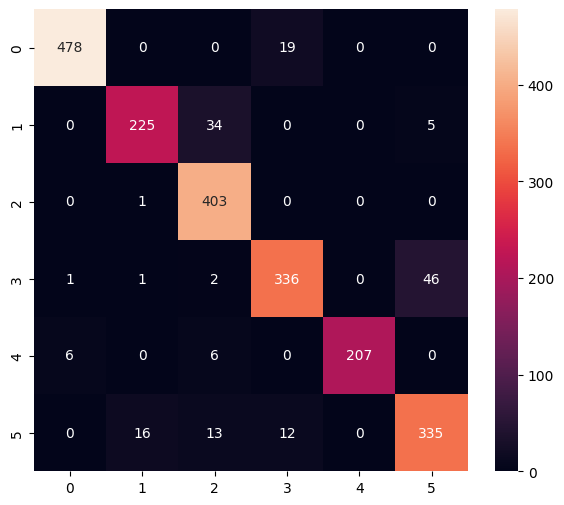

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       497
           1       0.93      0.85      0.89       264
           2       0.88      1.00      0.94       404
           3       0.92      0.87      0.89       386
           4       1.00      0.95      0.97       219
           5       0.87      0.89      0.88       376

    accuracy                           0.92      2146
   macro avg       0.93      0.92      0.92      2146
weighted avg       0.93      0.92      0.92      2146



In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [126]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [127]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_3.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpigsp1u_j/assets


INFO:tensorflow:Assets written to: /tmp/tmpigsp1u_j/assets
2024-01-11 10:35:18.057472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-11 10:35:18.057494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-11 10:35:18.057677: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpigsp1u_j
2024-01-11 10:35:18.058661: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-11 10:35:18.058673: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpigsp1u_j
2024-01-11 10:35:18.061174: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-11 10:35:18.105890: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpigsp1u_j
2024-01-11 10:35:18.121454: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

6696

# 推論テスト

In [128]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [129]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [130]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [131]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 123 µs, sys: 8 µs, total: 131 µs
Wall time: 120 µs


In [132]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.1490837e-02 1.5677986e-03 3.9888392e-04 4.3719560e-01 2.6687508e-04
 4.9908003e-01]
5
